# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Требуется построить модель с максимально большим значением *accuracy*, нужно довести долю правильных ответов по крайней мере до 0.75.

## Загрузка данных

In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc, mean_squared_error as mse, \
recall_score as recall, precision_score as precision, confusion_matrix, accuracy_score as accuracy, f1_score as f1

import matplotlib.pyplot as plt
import numpy as np

In [166]:
df = pd.read_csv('datasets/users_behavior.csv')

In [167]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


## Разбивка данных на выборки

В "Мегалайн" хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям тариф "Смарт" или "Ультра". Мы имеем дело с задачей классификации: по использованным услугам определим, какой тариф для них будет предпочтительнее.

In [169]:
x = df.drop('is_ultra', axis=1) #фичи
y = df['is_ultra'] #таргет

Поскольку нет заранее отложенной тестовой выборки, отнесем 60% наблюдений в train, 20% для валидации и 20% в test:

In [170]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

In [171]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=True) #0.8*0.25=0.2

In [172]:
x_val.shape[0] / df.shape[0]

0.2000622277535781

In [173]:
x_train.shape[0] / df.shape[0]

0.5998755444928439

In [174]:
x_test.shape[0] / df.shape[0]

0.2000622277535781

Соотношение размеров выборок верное.

## Исследование моделей

Для задачи классификации рассмотрим три семейства моделей: дерево решений, случайный лес и логистическую регрессию.

### Дерево решений

In [175]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

Проведем поиск оптимальной глубины дерева:

In [176]:
val_tree_scores = []
best_tree_score = 0
for depth in range(1,11):
    for sampl in range(2, 11, 2):
        tree = DecisionTreeClassifier(max_depth=depth, random_state=42, min_samples_leaf=sampl)
        tree.fit(x_train, y_train)
        
        if tree.score(x_val, y_val) > best_tree_score:
            best_tree = tree
            best_tree_score = tree.score(x_val, y_val)
    val_tree_scores.append(best_tree.score(x_val, y_val)) #сохраняем лучшее дерево для данной глубины
        
print('Лучшее дерево:', best_tree, 
      '\nAccuracy =', best_tree_score)

Лучшее дерево: DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=42) 
Accuracy = 0.7947122861586314


In [177]:
#plot_tree(best_tree)
#plt.show()

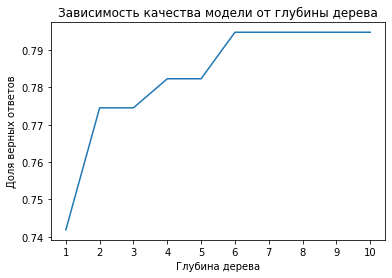

In [178]:
plt.plot(list(range(1,11)), val_tree_scores)
plt.xticks(list(range(1,11)))
plt.xlabel('Глубина дерева')
plt.ylabel('Доля верных ответов')
plt.title('Зависимость качества модели от глубины дерева')
plt.show()

На графике также видно, что наилучшее качество показывает дерево с глубиной 6 и больше не растет.

### Случайный лес

In [179]:
from sklearn.ensemble import RandomForestClassifier

Найдем оптимальное число деревьев, их глубину и обучим модель.

In [180]:
val_rf_scores = []
best_rf_score = 0
for depth in range(1,11):
    for n_est in range(100, 1001, 200):
        rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42)
        rf.fit(x_train, y_train)
            
        if rf.score(x_val, y_val) > best_rf_score:
            best_rf = rf
            best_rf_score = rf.score(x_val, y_val)
            
    val_rf_scores.append(best_rf_score) #сохраним лучшую оценку для текущей глубины

print('Лучший случайный лес:', best_rf, 
      '\nAccuracy =', best_rf_score)

Лучший случайный лес: RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42) 
Accuracy = 0.8087091757387247


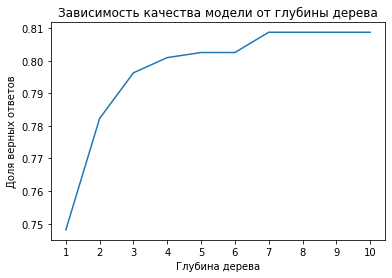

In [181]:
plt.plot(list(range(1,11)), val_rf_scores)
plt.xticks(list(range(1,11)))
plt.xlabel('Глубина дерева')
plt.ylabel('Доля верных ответов')
plt.title('Зависимость качества модели от глубины дерева')
plt.show()

Видно, что число деревьев больше 500 не повлияло на качество, и по достижении глубины 7 качество стало предельным.

### KFold для best_rf

In [182]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline

In [183]:
print('Лучший случайный лес:', best_rf, 
      '\nAccuracy =', best_rf_score)

Лучший случайный лес: RandomForestClassifier(max_depth=7, n_estimators=500, random_state=42) 
Accuracy = 0.8087091757387247


In [184]:
pipeline_rf = make_pipeline(best_rf)
scores = cross_val_score(pipeline_rf, x_train, y_train,
                         cv=5, #т.к int + классификатор, исп StratifiedKFold
                         scoring='accuracy')
print('Accuracy score:', scores)
print('Mean accuracy:', scores.mean())

Accuracy score: [0.76165803 0.8238342  0.82642487 0.82337662 0.7974026 ]
Mean accuracy: 0.8065392638449633


### Learning curves

Чтобы примерно оценить, как будет вести себя модель при добавлении новых данных, построим кривые обучения:

In [187]:
def plot_learning_curves(model, x, y):
    X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    train_score, val_score = [], []
    for n in np.linspace(0.2, 1.0, 4):
        m = int(n * len(X_train))
        model.fit(X_train[:m], Y_train[:m])
        train_score.append(model.score(X_train[:m], Y_train[:m]))
        val_score.append(model.score(X_val, Y_val))
    plt.plot(train_score, 'r-+', linewidth=1.5, label='train')
    plt.plot(val_score, 'b-', linewidth=1, label='val')
    plt.grid()
    plt.legend(loc='best')
    print('train_score:', train_score)
    print('val_score:', val_score)

train_score: [0.9066147859922179, 0.8715596330275229, 0.8594164456233422, 0.8490859587709063]
val_score: [0.7916018662519441, 0.80248833592535, 0.807153965785381, 0.8118195956454122]


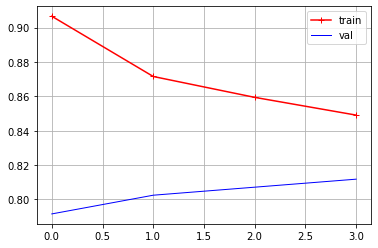

In [188]:
plot_learning_curves(pipeline_rf, x, y)

### Learning curves: Sklearn

In [189]:
#будет проводиться KFold, оставим только тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.model_selection import learning_curve
train_size_abs, train_scores, test_scores = learning_curve(
    pipeline_rf, x_train, y_train, 
    train_sizes=np.linspace(0.2, 1.0, 4),
    cv=5, #или cv=skf (если int то тоже исп. StratifiedKFold)
    shuffle=True,
    scoring='accuracy'
    )

#возвращаем валидационную выборку (с ней выполнялась вся остальная работа)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42, shuffle=True) #0.8*0.25=0.2

[0.9099756690997566, 0.8750782064650677, 0.8617120106171201, 0.85]
[0.7977515016433078, 0.797362396584942, 0.8020309017415285, 0.8032004835480336]


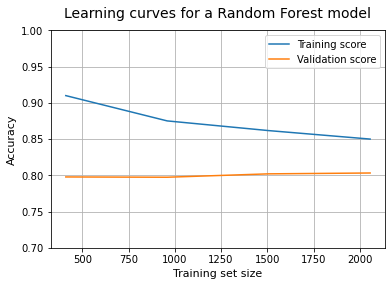

In [190]:
train_scores_mean, val_scores_mean = [], [] #сохраним средние оценки с валидации
for train_size, cv_train_scores, cv_val_scores in zip(train_size_abs, train_scores, test_scores):
    train_scores_mean.append(cv_train_scores.mean())
    val_scores_mean.append(cv_val_scores.mean())

#plt.style.use('ggplot')
plt.plot(train_size_abs, train_scores_mean, label = 'Training score')
plt.plot(train_size_abs, val_scores_mean, label = 'Validation score')
plt.ylabel('Accuracy', fontsize = 11)
plt.xlabel('Training set size', fontsize = 11)
plt.title('Learning curves for a Random Forest model', fontsize = 14, y = 1.03)
plt.legend()
plt.grid()
plt.ylim(0.7,1);
print(train_scores_mean)
print(val_scores_mean)

### Логистическая регрессия

In [191]:
from sklearn.linear_model import LogisticRegression

In [192]:
val_log_scores = []
best_log_score = 0
for iters in range(100, 501, 100):
    log_reg = LogisticRegression(random_state=42, solver='lbfgs', max_iter=iters)
    log_reg.fit(x_train, y_train)

    val_log_scores.append(tree.score(x_val, y_val))
    
    if log_reg.score(x_val, y_val) > best_log_score:
        best_log = log_reg
        best_log_score = log_reg.score(x_val, y_val)
        
print('Лучшая логистическая регрессия:', best_log, 
      '\nAccuracy =', best_log_score)

Лучшая логистическая регрессия: LogisticRegression(random_state=42) 
Accuracy = 0.7527216174183515


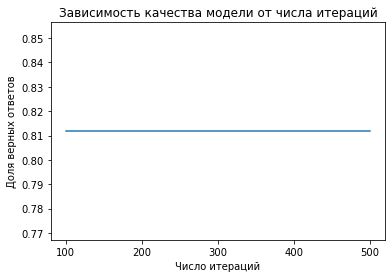

In [193]:
plt.plot(list(range(100, 501, 100)), val_log_scores)
plt.xticks(list(range(100, 501, 100)))
plt.xlabel('Число итераций')
plt.ylabel('Доля верных ответов')
plt.title('Зависимость качества модели от числа итераций')
plt.show()

Разное число итераций не влияет на качество модели. Точность получилась ниже 0.75, поэтому такая модель нам не подойдет. Для увеличения точности можно было бы собрать больше данных и увеличить размер обучающей выборки.

## Проверка модели на тестовой выборке

Нам подходят модели дерева решений `best_tree` и случайного леса `best_rf`. Их точность равна 0.799 и 0.815 соответственно. Оптимальная глубина деревьев 7, а оптимальное число деревьев в случайном лесе 500. Проверим их на тестовой выборке.

In [194]:
best_tree.score(x_test, y_test)

0.8211508553654744

In [195]:
best_rf.score(x_test, y_test)

0.8600311041990669

На тестовой выборке модели показали себя не хуже, чем на валидационной. Наилуший результат у случайного леса. С уже заданными гиперпараметрами он обучается достаточно быстро, поэтому такой выбор модели рентабелен.

## Проверка модели на адекватность

Рассчитаем дополнительные метрики классификации: точность (precision) и полноту (recall):

In [202]:
def scores(y_test, y_pred):
    print('precision = ', precision(y_test, y_pred))
    print('recall = ', recall(y_test, y_pred))
    print('accuracy = ', accuracy(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred).ravel()) #tn fp fn tp

In [203]:
scores(y_test, best_tree.predict(x_test))

precision =  0.8253968253968254
recall =  0.5279187817258884
accuracy =  0.8211508553654744
[424  22  93 104]


In [204]:
scores(y_test, best_rf.predict(x_test))

precision =  0.9495798319327731
recall =  0.5736040609137056
accuracy =  0.8600311041990669
[440   6  84 113]


***Точность*** указывает долю правильно предсказанных положительных объектов среди всех объектов, признанных положительным классом: `'is_ultra' = 1`. По развернутой матрице видим, что модели хорошо определяют пользователей тарифа "Ультра" (FalsePositive = 22 и 6). Когда всего положительных классов 197 (fn+tp) — треть выборки.

**Доля положительного класса в тестовой выборке:**

In [199]:
y_test.mean()

0.30637636080870917

Получается, что высокий accuracy обеспечивается в основном за счет члена TN: в выборке 70% нулевого класса и из них мы угадываем больше половины (424 и 440) — этим клиентам предложим тариф "Смарт".

***Полнота*** — доля верно выявленных положительных объектов среди всех объектов действительно являющихся положительными. <br>
Наши модели правильно выделяют положительный класс всего в 53% и 57% случаев соответственно: высокая доля значений FalseNegative (93 и 84) — это все упущенные шансы, на которых клиент оказался бы заинтересованным в новом тарифе.

Однако нас интересует верная классификация как TruePositive, так и TrueNegative — для тарифов Ультра и Смарт. Поэтому выбор метрики accuracy обоснован.

**F1-мера — среднее гармоническое между точностю и полнотой**

In [201]:
f1(y_test, best_rf.predict(x_test))

0.7151898734177216

*Можно сказать, что модель достаточно хорошо решает задачу, для которой предназначена.*